**SETUP AND IMPORTS**

In [ ]:
# Install Biopython

!pip install biopython
from Bio import SeqIO

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 27.2 MB/s eta 0:00:00


In [ ]:
# Imports & utilities

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from Bio import SeqIO

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

**UPLOAD AND VERIFY THE FASTA FILES**

In [ ]:
from google.colab import files
from Bio import SeqIO

# Upload the files code
print("Please upload the two FASTA files:")
print("1. ec1_oxidoreductase.fasta (Oxidoreductases)")
print("2. ec2_transferase.fasta (Transferases)\n")

uploaded = files.upload()

# Parse and inspect the uploaded sequences
for filename in uploaded.keys():
    print(f"\n--- Checking {filename} ---")
    try:
        records = list(SeqIO.parse(filename, "fasta"))
        print(f"Total sequences: {len(records)}")
        print("Example headers:")
        for record in records[:3]:
            print(" ", record.description)
    except Exception as e:
        print(f"Error reading {filename}: {e}")

print("\n✅ Upload complete. If EC1 and EC2 files loaded correctly, proceed to feature extraction.")


Please upload the two FASTA files:
1. ec1_oxidoreductase.fasta (Oxidoreductases)
2. ec2_transferase.fasta (Transferases)



Saving ec1_oxidoreductase.fasta to ec1_oxidoreductase.fasta
Saving ec2_transferase.fasta to ec2_transferase.fasta

--- Checking ec1_oxidoreductase.fasta ---
Total sequences: 448
Example headers:
  sp|P00350|6PGD_ECOLI 6-phosphogluconate dehydrogenase, decarboxylating OS=Escherichia coli (strain K12) OX=83333 GN=gnd PE=1 SV=2
  sp|P00363|FRDA_ECOLI Fumarate reductase flavoprotein subunit OS=Escherichia coli (strain K12) OX=83333 GN=frdA PE=1 SV=3
  sp|P00370|DHE4_ECOLI NADP-specific glutamate dehydrogenase OS=Escherichia coli (strain K12) OX=83333 GN=gdhA PE=1 SV=1

--- Checking ec2_transferase.fasta ---
Total sequences: 858
Example headers:
  sp|P00490|PHSM_ECOLI Maltodextrin phosphorylase OS=Escherichia coli (strain K12) OX=83333 GN=malP PE=1 SV=7
  sp|P00509|AAT_ECOLI Aspartate aminotransferase OS=Escherichia coli (strain K12) OX=83333 GN=aspC PE=1 SV=1
  sp|P00550|PTM3C_ECOLI PTS system mannitol-specific EIICBA component OS=Escherichia coli (strain K12) OX=83333 GN=mtlA PE=1 SV=1

✅

**EXTRACTS THE FEATURES (IN MY CASE IT IS THE AMINO ACID COMPOSITION)**

In [ ]:
import pandas as pd
from Bio import SeqIO

# Define the 20 standard amino acids
amino_acids = list("ACDEFGHIKLMNPQRSTVWY")

def compute_composition(record):
    seq = str(record.seq).upper()
    length = len(seq)
    counts = {aa: seq.count(aa) / length for aa in amino_acids}
    return counts

def fasta_to_dataframe(fasta_file, label):
    data = []
    for record in SeqIO.parse(fasta_file, "fasta"):
        comp = compute_composition(record)
        comp["label"] = label
        data.append(comp)
    return pd.DataFrame(data)

# Convert both FASTA files into numeric tables
df_ec1 = fasta_to_dataframe("ec1_oxidoreductase.fasta", 1)  # EC1 = oxidoreductases
df_ec2 = fasta_to_dataframe("ec2_transferase.fasta", 2)     # EC2 = transferases

# Combine them into one dataset
df_all = pd.concat([df_ec1, df_ec2], ignore_index=True)
print("Combined dataset shape:", df_all.shape)
df_all.head()



Combined dataset shape: (1306, 21)


,A,C,D,E,F,G,H,I,K,L,...,N,P,Q,R,S,T,V,W,Y,label
0,0.108974,0.004274,0.057692,0.072650,0.036325,0.087607,0.008547,0.074786,0.059829,0.085470,...,0.042735,0.034188,0.044872,0.042735,0.053419,0.047009,0.061966,0.008547,0.053419,1
1,0.101329,0.016611,0.058140,0.073090,0.033223,0.109635,0.034884,0.038206,0.044850,0.079734,...,0.038206,0.036545,0.036545,0.063123,0.033223,0.059801,0.068106,0.011628,0.028239,1
2,0.105145,0.008949,0.042506,0.069351,0.049217,0.109620,0.022371,0.038031,0.049217,0.078300,...,0.038031,0.033557,0.051454,0.049217,0.049217,0.049217,0.082774,0.011186,0.022371,1
3,0.089862,0.009217,0.041475,0.052995,0.025346,0.096774,0.039171,0.059908,0.057604,0.117512,...,0.052995,0.039171,0.032258,0.050691,0.046083,0.059908,0.062212,0.004608,0.027650,1
4,0.126214,0.000000,0.058252,0.063107,0.053398,0.063107,0.038835,0.029126,0.082524,0.097087,...,0.058252,0.043689,0.029126,0.029126,0.053398,0.043689,0.048544,0.029126,0.033981,1


In [ ]:
# Verify amino acid composition calculations

# Drop the label column and sum all amino acid columns per sequence
row_sums = df_all.drop(columns="label").sum(axis=1)

# Display descriptive statistics
print(row_sums.describe())

# Optional: check a few sequences that don't sum close to 1.0 (should be none)
off_rows = df_all.loc[(row_sums < 0.99) | (row_sums > 1.01)]
print("Rows with unexpected totals:", off_rows.shape[0])

count    1306.000000
mean        0.999997
std         0.000055
min         0.998601
25%         1.000000
50%         1.000000
75%         1.000000
max         1.000000
dtype: float64
Rows with unexpected totals: 0


**Balance the data (400 for each type)**

In [ ]:
# Balance the dataset by random subsampling

# Randomly sample 400 sequences per class
df_ec1_sample = df_all[df_all["label"] == 1].sample(n=400, random_state=42)
df_ec2_sample = df_all[df_all["label"] == 2].sample(n=400, random_state=42)

# Combine them into one balanced dataset
df_balanced = pd.concat([df_ec1_sample, df_ec2_sample], ignore_index=True)

# Shuffle the rows to mix classes
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Check the balance
print("Balanced dataset shape:", df_balanced.shape)
print(df_balanced["label"].value_counts())

Balanced dataset shape: (800, 21)
label
2    400
1    400
Name: count, dtype: int64


### **Train and Split Data**

In [ ]:
# --- Step 5: Split into training and testing sets (25% test size) ---

# Separate features (X) and labels (y)
X = df_balanced.drop(columns="label")
y = df_balanced["label"]

# Create 75% training and 25% testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.25,        # 25% test set to match class tutorial
    random_state=42,       # reproducible randomness
    stratify=y             # keeps the 1:1 class ratio in both sets
)

print("Training set size:", X_train.shape[0])
print("Testing set size:", X_test.shape[0])


Training set size: 600
Testing set size: 200


# **Supervised Classifiers**

### **Baseline classifiers with Pipelines**

In [ ]:
from sklearn.metrics import roc_auc_score

models = {
    "LogReg": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(
            max_iter=500,
            multi_class="auto",
            random_state=RANDOM_STATE
        ))
    ]),

    "RF": Pipeline([
        ("clf", RandomForestClassifier(
            n_estimators=300,
            random_state=RANDOM_STATE
        ))
    ]),

    "SVM": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", SVC(
            kernel="rbf",
            probability=True,   # required for ROC AUC
            random_state=RANDOM_STATE
        ))
    ])
}

results = {}

for name, pipe in models.items():
    pipe.fit(X_train, y_train)

    # Predictions
    pred = pipe.predict(X_test)
    proba = pipe.predict_proba(X_test)

    # Metrics
    acc = accuracy_score(y_test, pred)

    # ROC AUC (binary classification)
    try:
        auc = roc_auc_score(y_test, proba[:,1])
    except Exception:
        auc = np.nan

    results[name] = {
        "accuracy": acc,
        "roc_auc": auc
    }

pd.DataFrame(results).T

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


,accuracy,roc_auc
LogReg,0.65,0.71170
RF,0.79,0.87785
SVM,0.74,0.80170


### **Confusion Matrix (Finding the Best Model)**

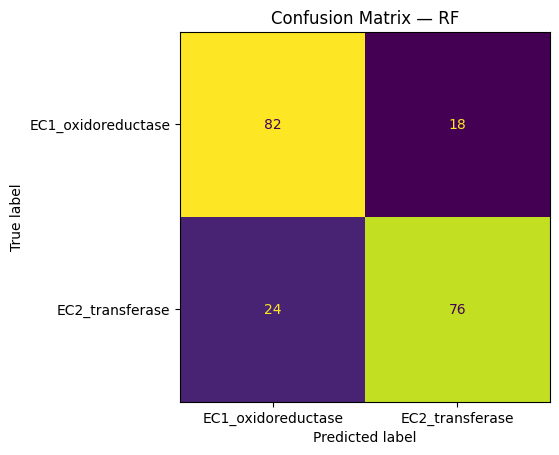

                    precision    recall  f1-score   support

EC1_oxidoreductase       0.77      0.82      0.80       100
   EC2_transferase       0.81      0.76      0.78       100

          accuracy                           0.79       200
         macro avg       0.79      0.79      0.79       200
      weighted avg       0.79      0.79      0.79       200



In [ ]:
# --- Step 6b: Confusion Matrix for Best Model (class style) ---

# Determine which model has the highest accuracy
best = max(results.items(), key=lambda kv: kv[1]["accuracy"])[0]
best_pipe = models[best]

# Predict on the test set
pred = best_pipe.predict(X_test)

# Custom class names for your project
class_names = ["EC1_oxidoreductase", "EC2_transferase"]

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, pred),
                              display_labels=class_names)

fig, ax = plt.subplots()
disp.plot(ax=ax, colorbar=False)
plt.title(f"Confusion Matrix — {best}")
plt.show()

# Classification report
print(classification_report(y_test, pred, target_names=class_names))

### **Cross Validation**

In [ ]:
# --- Step 6c: Hyperparameter tuning with 5-fold cross validation (small & fast grid) ---

from sklearn.model_selection import StratifiedKFold, GridSearchCV

# Create stratified 5-fold splitter (keeps 50/50 class balance in each fold)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Small, fast hyperparameter search grids (optimized for your dataset)
param_grid = {
    "LogReg": {
        "clf__C": [0.1, 1.0]
    },

    "RF": {
        "clf__n_estimators": [200],
        "clf__max_depth": [None]
    },

    "SVM": {
        "clf__C": [1],
        "clf__gamma": ["scale"]
    }
}

# Dictionary to store tuned results
tuned = {}

for name, pipe in models.items():
    print(f"Tuning {name}...")

    grid = GridSearchCV(
        pipe,
        param_grid[name],
        cv=cv,
        scoring="f1_macro",    # better metric for your project
        n_jobs=-1
    )

    grid.fit(X_train, y_train)

    tuned[name] = {
        "best_score": grid.best_score_,
        "best_params": grid.best_params_,
        "estimator": grid.best_estimator_
    }

# Display results
pd.DataFrame({
    k: {
        "cv_f1_best": v["best_score"],
        **v["best_params"]
    }
    for k, v in tuned.items()
}).T

Tuning LogReg...


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Tuning RF...
Tuning SVM...


,cv_f1_best,clf__C,clf__max_depth,clf__n_estimators,clf__gamma
LogReg,0.602439,1.0,NaN,NaN,NaN
RF,0.738063,NaN,NaN,200.0,NaN
SVM,0.678571,1,NaN,NaN,scale


### **Binary ROC Curve**

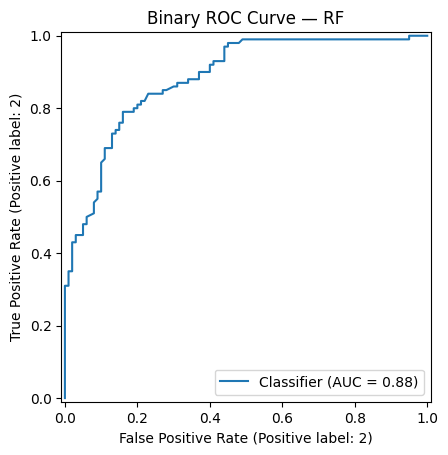

AUC: 0.8836499999999999


In [ ]:
# --- Binary ROC Curve for best tuned model (corrected for labels 1 and 2) ---

from sklearn.metrics import RocCurveDisplay, roc_auc_score

# Find best model
best_name = max(tuned.items(), key=lambda kv: kv[1]["best_score"])[0]
best_model = tuned[best_name]["estimator"]

# Fit best model on training data
best_model.fit(X_train, y_train)

# Probability of class 2 (EC2_transferase)
y_score = best_model.predict_proba(X_test)[:, 1]

# Plot ROC curve (specify positive class)
RocCurveDisplay.from_predictions(y_test, y_score, pos_label=2)
plt.title(f"Binary ROC Curve — {best_name}")
plt.show()

# Print AUC
auc_value = roc_auc_score(y_test, y_score)
print("AUC:", auc_value)

### **PCA Visualization**

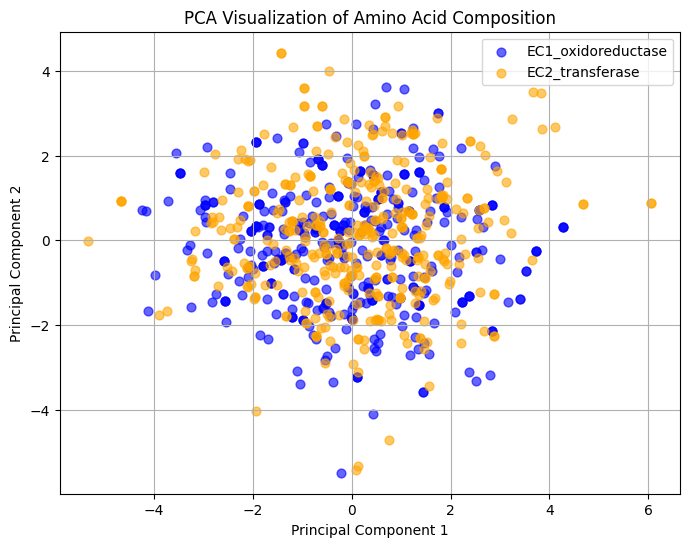

Explained variance ratios: [0.1359136  0.11209597]


In [ ]:
# --- Step 7: PCA visualization of amino acid composition features ---

from sklearn.decomposition import PCA

# Extract features only (no labels)
X_features = df_balanced.drop(columns="label")
y_labels = df_balanced["label"]

# Standardize before PCA (important)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_features)

# Run PCA for 2D visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Create PCA dataframe
pca_df = pd.DataFrame({
    "PC1": X_pca[:, 0],
    "PC2": X_pca[:, 1],
    "label": y_labels
})

# Plot
plt.figure(figsize=(8,6))
colors = {1: "blue", 2: "orange"}
labels = {1: "EC1_oxidoreductase", 2: "EC2_transferase"}

for l in [1, 2]:
    subset = pca_df[pca_df["label"] == l]
    plt.scatter(subset["PC1"], subset["PC2"],
                label=labels[l], alpha=0.6, s=40, color=colors[l])

plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Visualization of Amino Acid Composition")
plt.legend()
plt.grid(True)
plt.show()

# Variance explained
print("Explained variance ratios:", pca.explained_variance_ratio_)
